In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
!git clone https://github.com/leeprinxin/Project-1-WaterMeter.git

Cloning into 'Project-1-WaterMeter'...
remote: Enumerating objects: 50009, done.
remote: Total 50009 (delta 0), reused 0 (delta 0), pack-reused 50009
Receiving objects: 100% (50009/50009), 206.09 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (50010/50010), done.


探索數據

In [3]:
#defining directory paths
image_dir = '/content/Project-1-WaterMeter/analog_clocks/images'
labels_dir = '/content/Project-1-WaterMeter/analog_clocks/label.csv'

In [4]:
#examining labels
labels = pd.read_csv(labels_dir)
labels.describe()

,hour,minute
count,50000.000000,50000.000000
mean,5.522940,29.531240
std,3.459953,17.210759
min,0.000000,0.000000
25%,3.000000,15.000000
50%,6.000000,30.000000
75%,9.000000,44.000000
max,11.000000,59.000000


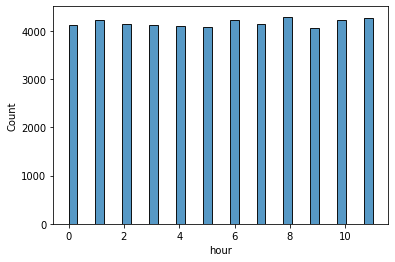

In [5]:
sns.histplot(labels.hour)

In [6]:
labels.hour

0         4
1         9
2         3
3         3
4         2
         ..
49995    11
49996     3
49997     4
49998     7
49999     8
Name: hour, Length: 50000, dtype: int64

In [7]:
labels.hour.value_counts()

8     4290
11    4273
6     4231
10    4226
1     4214
2     4145
7     4143
3     4124
0     4123
4     4090
5     4082
9     4059
Name: hour, dtype: int64

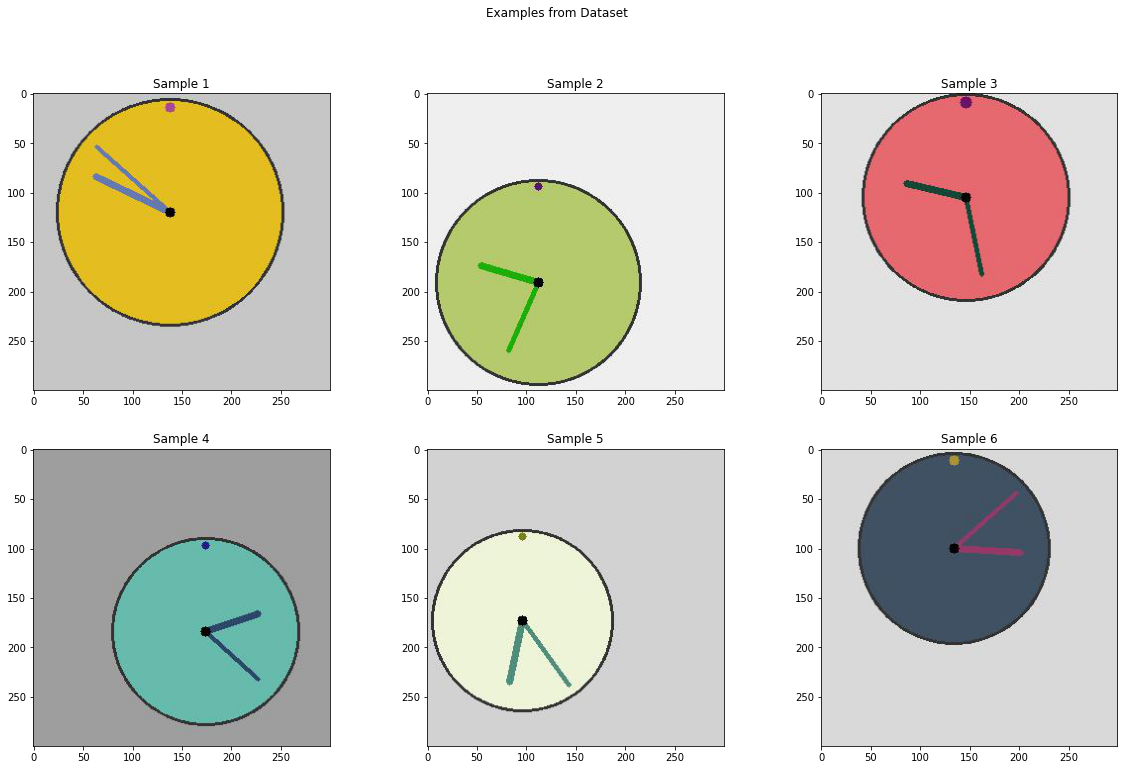

In [8]:
#preview of dataset
sample_dir = '/content/Project-1-WaterMeter/analog_clocks/samples'
fig = plt.figure(figsize=(20, 12))
plt.suptitle('Examples from Dataset')
for i, file in enumerate(os.listdir(sample_dir)):
    img = image.load_img(os.path.join(sample_dir, file),
                         interpolation='box')
    img = image.img_to_array(img, dtype='float32')
    img /= 255.0
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Sample ' + str(i+1))

資料處理

In [9]:
#transforming labels to multi-label binary format
labels_df = pd.read_csv(labels_dir)
labels_df['tuples'] = [tuple(x) for x in labels_df.values]
labels_df['tuples'] = [('h' + str(x), 'm' + str(y)) for x,y in labels_df['tuples'].values]
labels_df = labels_df.drop(columns=['hour', 'minute'])
# labels_df = labels_df.reset_index()
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(labels_df['tuples'])

In [10]:
binarizer.classes_

array(['h0', 'h1', 'h10', 'h11', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8',
       'h9', 'm0', 'm1', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16',
       'm17', 'm18', 'm19', 'm2', 'm20', 'm21', 'm22', 'm23', 'm24',
       'm25', 'm26', 'm27', 'm28', 'm29', 'm3', 'm30', 'm31', 'm32',
       'm33', 'm34', 'm35', 'm36', 'm37', 'm38', 'm39', 'm4', 'm40',
       'm41', 'm42', 'm43', 'm44', 'm45', 'm46', 'm47', 'm48', 'm49',
       'm5', 'm50', 'm51', 'm52', 'm53', 'm54', 'm55', 'm56', 'm57',
       'm58', 'm59', 'm6', 'm7', 'm8', 'm9'], dtype=object)

In [11]:
labels_df['tuples'].value_counts()

(h4, m4)      94
(h7, m22)     94
(h10, m48)    93
(h1, m24)     92
(h6, m32)     92
              ..
(h6, m27)     48
(h9, m7)      47
(h2, m30)     47
(h9, m48)     47
(h7, m35)     46
Name: tuples, Length: 720, dtype: int64

In [12]:
#creating train-test split
train, test = train_test_split(labels_df, 
                               stratify=labels_df['tuples'],
                               test_size=0.20,
                               random_state=42
                              )

train_idx, test_idx = list(train.index), list(test.index)

In [13]:
def generate(image_directory, labels, train_idx=None, batch_size=64, size=(224, 224)):
    
    """
    Function to create generator of images and labels for the neural network. This allows for training
    the model with the limited memory available. The images and labels are generated in batches of a given size.
    The images are loaded, added to a batch, preprocessed and have their features extracted using a prebuilt model
    (in this case Xception Model). 
    
    Parameters
    ----------
    image_directory: str
        The path where the images are located
    labels: array-like or list
        list of labels in multi-label binary format
    batch_size: int, default=64
        the number of images per batch
    size: tuple, default=(224, 224)
        the height and width to which the image is resized. 
    
    Yields
    ------
    image_batch: array
        Array of image features of size=batch_size
    labels_batch: array
        Array of labels in multi-label binary format of size=batch_size
    
    """
    
   
    prebuilt_model = xception.Xception(include_top=True,                      
              weights='imagenet')                                            #loading prebuilt model
    
    xception_model = Model(inputs=prebuilt_model.input,        
                           outputs=prebuilt_model.layers[-2].output)         #repurposing prebuilt model for feature extraction
    
    
    
    while 1:
        
        if train_idx==None:
            image_filenames = os.listdir(image_directory)                    #obtaining list of image filenames
        else:
            image_filenames = [str(idx) + '.jpg' for idx in train_idx]
            
        random.shuffle(image_filenames)                                      #shuffling the list to add randomness every epoch

        
        image_batch = []                                                     #initializing empty image batch list
        labels_batch = []                                                    #initializing empty labels batch list
        
        for file in image_filenames:                                         #looping over all images in directory

            index = int(file.split('.')[0])                                  #extracting image number/index from filename
            
            img = image.load_img(os.path.join(image_directory, file),        #loading image
                                 target_size=size,
                                 interpolation='box')
            
            img_arr = image.img_to_array(img, dtype='float32')               #converting image to array
            
            label = labels[index]                                            #using image number/index to find correct label in dataframe
    
            image_batch.append(img_arr)                                      #appending the image to the batch
            labels_batch.append(label)                                       #appending the label to the batch

    
            if len(image_batch)==batch_size:                                 #check to see if batch has required size
                image_batch = np.array(image_batch)                          #converting image batch list to array
                image_batch = xception.preprocess_input(image_batch)         #using xception preprocessing on image batch array
                image_features = xception_model.predict(image_batch)         #using prebuilt xception model to extract features from batch
                image_batch = np.array(image_features)                       #converting features to array
                image_batch = image_batch.reshape(batch_size,                #reshaping feature array
                                                  image_features.shape[1])   
                labels_batch = np.array(labels_batch)                        #converting labels batch list to array
                yield image_batch, labels_batch                              #yielding image and labels batch array
                image_batch = []                                             #reinitializing the image batch
                labels_batch = []                                            #reinitializing the label batch
                gc.collect()                                                 #collecting garbage to free memory

In [14]:
#Defining training parameters
BATCH_SIZE = 32
IMAGE_SIZE = (299, 299) #this is the size suggested for Xception model
EPOCHS = 10
STEPS = int(len(train_idx) / BATCH_SIZE)

In [15]:
#testing generator
sample_generator = next(generate(image_directory=image_dir, 
                                 labels=y,
                                 train_idx=train_idx,
                                 batch_size=16, 
                                 size=IMAGE_SIZE))

91897856/91884032 [==============================] - 2s 0us/step


In [16]:
sample_generator

(array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.2959507e-03,
         6.7736857e-02, 2.3959852e-03],
        [0.0000000e+00, 0.0000000e+00, 1.8067649e-03, ..., 1.5215798e-01,
         2.1184500e-01, 1.7403822e-01],
        [0.0000000e+00, 3.5074729e-02, 0.0000000e+00, ..., 2.5149900e-01,
         7.6481283e-02, 8.1983628e-03],
        ...,
        [0.0000000e+00, 2.0956891e-03, 0.0000000e+00, ..., 4.0693325e-01,
         7.3021218e-02, 4.6964474e-02],
        [0.0000000e+00, 0.0000000e+00, 2.1909108e-02, ..., 7.1123041e-02,
         2.2065987e-01, 3.0214319e-02],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.9018155e-02,
         2.9797164e-01, 8.5101987e-05]], dtype=float32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [17]:
#extracting input and output dims from generator
INPUT_DIM = sample_generator[0][0].shape
OUTPUT_DIM = sample_generator[1][0].shape[0]
INPUT_DIM, OUTPUT_DIM

((2048,), 72)

In [18]:
def create_model(input_shape, output_shape):
    
    """
    Function to build and compile neural network to predict analog clocks from images
    
    Parameters
    ----------
    input_shape: tuple
        Shape tuple not including the batch_size, example: (2048, )
    output_shape: int
        Number of nodes in final layer
    
    Returns
    -------
    model: Keras model object
        A compiled Keras model
    """

    input_layer = Input(shape=input_shape)
    norm  = BatchNormalization()(input_layer)
    drop = Dropout(0.25)(norm)
    fc1 = Dense(256, activation='relu')(norm)
    fc2 = Dense(256, activation='relu')(fc1)
    output1 = Dense(output_shape, activation='sigmoid')(fc2)
    
    #contructing model from layers
    model = Model(inputs=input_layer,
                  outputs=output1)
    
    #compiling model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )
    
    return model

In [19]:

#creating instance of model
model = create_model(input_shape=INPUT_DIM,
                     output_shape=OUTPUT_DIM)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2048)]            0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 72)                18504     
                                                                 
Total params: 617,032
Trainable params: 612,936
Non-trainable params: 4,096
_________________________________________________

In [21]:
generator = generate(image_directory=image_dir,
                     labels=y,
                     train_idx=train_idx,
                     batch_size=BATCH_SIZE, 
                     size=IMAGE_SIZE)

In [ ]:
#fitting model
history = model.fit(generator, 
                    epochs=EPOCHS, 
                    steps_per_epoch=STEPS)

In [23]:
def predict(image_directory, indices=None, plot=False):
    
    """
    Function to predict all images in a given path
    
    Parameters
    ----------
    image_directory: str
        Path for images to be predicted
    indices: list, default = None
        Indices corresponding to image labels to predict
    plot: boolean, default=False
        Whether or not to create plot of predictions
        
    Returns
    -------
    predictions_list: list
        List of predictions corresponding to the images
    """
    
    images_list = []
    
    prebuilt_model = xception.Xception(include_top=True,
                                       weights='imagenet')           #loading pre-built model
    
    xception_model = Model(inputs=prebuilt_model.input,
                           outputs=prebuilt_model.layers[-2].output) #repurposing pre-built model for feature extraction
    
    if indices!=None:
        image_filenames = [str(idx) + '.jpg' for idx in indices]
    else:
        image_filenames = os.listdir(image_directory)
    
    if plot:
        dim = int(np.ceil(np.sqrt(len(image_filenames))))
        fig, axs = plt.subplots(nrows=dim, 
                                ncols=dim,
                                figsize=(20, 14))
        plt.suptitle('Example of Model Predictions', fontsize=32)
        
#         axs = axs.flatten()
        
    
    #looping over all images in path
    for i, file in enumerate(image_filenames):
        

        img = image.load_img(os.path.join(image_directory,
                                          file))                     #loading images
        img_arr = image.img_to_array(img, dtype='float32')           #converting images to array
    
        if plot:
            axs.flat[i].imshow(img_arr/255.0)
            
        images_list.append(img_arr)
        gc.collect()       
    
    print('preprocessing...')
    images_list = np.array(images_list)
    img_arr = xception.preprocess_input(images_list)                 #preprocessing image array using xception method
    print('extracting features...')
    img_features = xception_model.predict(img_arr)                   #extracting features from image using prebuilt xception model
    img_features = np.array(img_features)
    print('predicting...')
    prediction = model.predict(img_features)                         #predicting time from image features                        
    hour_max = np.argmax(prediction[:, :12], axis=1)                 #obtaining hour with the highest probability
    minute_max = np.argmax(prediction[:, 12:], axis=1) + 12          #obtaining minute with the highest probability
    prediction_list = [(binarizer.classes_[x],                       #getting labels for predictions for binarizer
                        binarizer.classes_[y]) 
                        for (x,y) in list(zip(hour_max, minute_max))]

    if plot:                                                         #setting title for plots
        for i, v in enumerate(prediction_list):
            axs.flat[i].set_title(str(v[0]) + ' ' + str(v[1]))
            axs.flat[i].axis('off')
        for j in range(i+1, dim**2):                                 #removing excess subplots
              fig.delaxes(axs.flat[j])
            
    return prediction_list

In [ ]:
predictions = predict('/content/Project-1-WaterMeter/analog_clocks/samples',
                        plot=True)